## Device check

In [1]:
!nvidia-smi

Fri Oct 27 12:02:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |
| N/A   30C    P0    41W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Packages

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:

import lightning.pytorch as pl
import logging
logging.basicConfig(level="INFO")

import math
from matplotlib import pyplot

import numpy as np

import os

import pandas as pd
from pprint import pprint

import sys
sys.path.append("../src")

import timm
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
%load_ext autoreload
%autoreload 2

In [5]:
from einops import pack, unpack, repeat, reduce, rearrange

In [117]:
import config
from dataloader import BEDataset, BEDataModule
import token_learner
from transformer import PositionalEncoder, MultiHeadSelfAttention, MultiHeadCrossAttention, FeedFowardLayer, LayerNormalization, TransformerDecoderLayer, TransformerDecoder, generate_masks, generate_causal_attention_mask

from film_layers import FiLMBlockV2, FiLMEncoder, ResBlockDWConv
from rt1 import RT1Encoder, ActionGenerator
from utils.data_utils import History
from utils.model_utils import TextEncoder, ImageFeatureExtractor, plot_self_attention, plot_cross_attention


## Data Module

In [7]:
dm = BEDataModule()
dm.setup()

Total # examples: 4876


INFO:root:Training on 3915 samples.
INFO:root:Validating on 961 samples.


## Fetch batch

In [8]:
%%time
sample = next(iter(dm.train_dataloader()))
sample["in_state"].shape

CPU times: user 1.08 s, sys: 909 ms, total: 1.99 s
Wall time: 6.18 s


torch.Size([4, 3, 288, 288])

## Model Design

<!-- ![RT1 model architecture](../../imgs/rt1+.png) -->
<center>
    <img src="../imgs/rt1+.png" alt="RT1 model architecture" width="300" height="400">

<center>

### Encoder

#### Test Text Encoder

In [110]:
# te = TextEncoder(freeze=True).cuda()
# summary(model=te, col_names=["num_params", "trainable"])

In [109]:
# emb = te(
#     inp_ids=sample["action_desc"]["ids"].cuda(),
#     mask=sample["action_desc"]["mask"].cuda(),
#     tok_type_ids=sample["action_desc"]["token_type_ids"].cuda()
# )

# emb.shape

torch.Size([4, 512])

#### Test Img Feature Extractor

In [ ]:
# fe = ImageFeatureExtractor(pretrained=True, arch="efficientnet_b3").cuda()

# summary(fe, col_names=["num_params", "trainable"])

In [ ]:
# img_ftrs = fe(sample["in_state"].cuda())

# img_ftrs.shape

#### Test FiLM Block

In [16]:
# film_block = FiLMBlockV2().cuda()
# print(film_block)
# summary(model=film_block)

In [17]:
# text_cond_ftrs = film_block(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs.shape

#### Test Residual FiLM Block

In [18]:
# dw_res = ResBlockDWConv(512, 512).cuda()
# summary(model=dw_res)

In [19]:
# text_cond_ftrs_res = dw_res(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs_res.shape

#### Test FiLM Encoder

In [20]:
# film_encoder = FiLMEncoder(
#     arch="resnet34",
#     n_res_blocks=6,
# ).cuda()

# # print(film_encoder)
# summary(model=film_encoder)

In [21]:
# %%time

# out = film_encoder(
#     x= sample["in_state"].cuda(),
#     conditioning= emb
# )

# out.shape

#### Token Learner

In [22]:
# N, C, H_W = out.shape
# N, C, H_W

In [23]:
# tokL_v11 = token_learner.TokenLearnerModuleV11(feature_shape=(N, H_W, C)).cuda()
# print(tokL_v11)
# summary(model=tokL_v11)

In [24]:
# learned_tokens = tokL_v11(out.view(N, H_W, C))
# learned_tokens.shape

In [154]:
tokenized_inputs = torch.empty((B, config.NUM_HISTORY+1, config.D_MODEL, config.NUM_LEARNED_TOKENS))
tokenized_inputs.shape

torch.Size([8, 6, 512, 8])

#### RT-1 Encoder

In [9]:
encoder = RT1Encoder(
    cnn_bacnbone="efficientnet_b3", 
    num_res_blocks=6, 
    freeze_cnn_backbone=True
).to(config.DEVICE)

summary(model=encoder, col_names=["num_params", "trainable"])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─EfficientNetFeatures: 3-4                        (1

In [10]:
%%time 

src_enc, tokens = encoder._encode(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

src_enc.shape, tokens.shape

CPU times: user 978 ms, sys: 913 ms, total: 1.89 s
Wall time: 11.4 s


(torch.Size([4, 512]), torch.Size([4, 512, 8]))

In [11]:
%%time

src_enc, tokenized_inputs = encoder(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

tokenized_inputs.shape, tokenized_inputs.device

CPU times: user 222 ms, sys: 24 ms, total: 246 ms
Wall time: 991 ms


(torch.Size([4, 48, 512]), device(type='cuda', index=0))

### Decoder

In [12]:
pos_encoding = PositionalEncoder(seq_len=config.NUM_TOKENIZED_INPUTS).cuda()

In [13]:
pos_enc = pos_encoding(tokenized_inputs)
print(pos_enc.shape)

learned_tokens = tokenized_inputs + pos_enc

torch.Size([4, 48, 512])


In [30]:
inp = sample["action_desc"]["ids"]
outp = sample["motor_cmd"]["ids"]

# inp_seq = input_seq_embedding(inp.cuda())
# outp_seq = target_seq_embedding(outp.cuda())
inp_seq_lens = sample["action_desc"]["length"]
outp_seq_lens = sample["motor_cmd"]["length"]

# inp_seq.shape, outp_seq.shape,inp_seq_lens, outp_seq_lens

#### Test Cross Attention Layer

In [14]:
# num_heads = 4
# cross_attention = MultiHeadCrossAttention(
#     embed_dim=512, 
#     num_heads=num_heads, 
#     dropout_rate=0.1
# ).cuda()

# print(cross_attention)
# summary(cross_attention)

In [15]:
# input_seq_embedding = encoder.text_encoder.text_encoder.embeddings.cuda()

# print(input_seq_embedding)
# summary(input_seq_embedding)

In [16]:
# target_seq_embedding = nn.Sequential(
#     nn.Embedding(
#         num_embeddings=config.TARGET_VOCAB_SIZE, 
#         embedding_dim=config.EMBEDDING_DIM, 
#         padding_idx=config.TGT_PAD_TOK_ID
#     ),
#     LayerNormalization(),
#     nn.Dropout(p=.1)
    
# ).cuda()
# cross_attention.eval()

# print(target_seq_embedding)
# summary(target_seq_embedding)


In [18]:
# inp, inp.shape

In [19]:
# outp, outp.shape

In [20]:
# attention_output, attention_w = cross_attention(inp_seq, inp_seq_lens, outp_seq)

# attention_output.shape, attention_w.shape

#### Plot Cross attention weights

In [21]:
# plot_cross_attention(attention_w, inp_seq_lens=inp_seq_lens, outp_seq_lens=outp_seq_lens)
# plot_cross_attention(attention_w, inp_seq_lens=inp_seq_lens, outp_seq_lens=outp_seq_lens, example_idx=2)

#### Test MultiHead Self-Attention Layer

In [22]:
# mhsa = MultiHeadSelfAttention().cuda()
# print(mhsa)
# summary(mhsa)

In [23]:
# mem, attn_w = mhsa(inp=learned_tokens, return_weights=True)

# mem.shape, attn_w.shape

#### Plot Self-attention weights

In [24]:
# plot_self_attention(attn_w)
# plot_self_attention(attn_w, example_idx=2)

#### Test Transformer decoder layer

In [26]:
dec_layer = TransformerDecoderLayer().cuda()
print(dec_layer)
summary(dec_layer)

TransformerDecoderLayer(
  (self_attn): MultiHeadSelfAttention(
    (attention_heads): ModuleList(
      (0-7): 8 x SelfAttentionHead(
        (dropout): Dropout(p=0.15, inplace=False)
        (_softmax): Softmax(dim=-1)
        (w_q): Linear(in_features=512, out_features=512, bias=False)
        (w_k): Linear(in_features=512, out_features=512, bias=False)
        (w_v): Linear(in_features=512, out_features=512, bias=False)
      )
    )
    (output_layer): Sequential(
      (0): Linear(in_features=4096, out_features=512, bias=False)
      (1): Dropout(p=0.15, inplace=False)
    )
  )
  (cross_attn): MultiHeadCrossAttention(
    (attention_heads): ModuleList(
      (0-7): 8 x CrossAttentionHead(
        (w_k_input): Linear(in_features=512, out_features=512, bias=False)
        (w_v_input): Linear(in_features=512, out_features=512, bias=False)
        (w_q_output): Linear(in_features=512, out_features=512, bias=False)
        (dropout): Dropout(p=0.15, inplace=False)
        (_softmax):

Layer (type:depth-idx)                   Param #
TransformerDecoderLayer                  --
├─MultiHeadSelfAttention: 1-1            --
│    └─ModuleList: 2-1                   --
│    │    └─SelfAttentionHead: 3-1       786,432
│    │    └─SelfAttentionHead: 3-2       786,432
│    │    └─SelfAttentionHead: 3-3       786,432
│    │    └─SelfAttentionHead: 3-4       786,432
│    │    └─SelfAttentionHead: 3-5       786,432
│    │    └─SelfAttentionHead: 3-6       786,432
│    │    └─SelfAttentionHead: 3-7       786,432
│    │    └─SelfAttentionHead: 3-8       786,432
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-9                  2,097,152
│    │    └─Dropout: 3-10                --
├─MultiHeadCrossAttention: 1-2           --
│    └─ModuleList: 2-3                   --
│    │    └─CrossAttentionHead: 3-11     786,432
│    │    └─CrossAttentionHead: 3-12     786,432
│    │    └─CrossAttentionHead: 3-13     786,432
│    │    └─CrossAttentionHead: 3-14     786,432
│   

In [31]:
dec_out, self_attn_w, cross_attn_w = dec_layer(
    learned_tokens, 
    inp_lens=inp_seq_lens, 
    debug=False
)
dec_out.shape, self_attn_w.shape, cross_attn_w.shape

(torch.Size([4, 48, 512]),
 torch.Size([4, 8, 48, 48]),
 torch.Size([4, 8, 48, 48]))

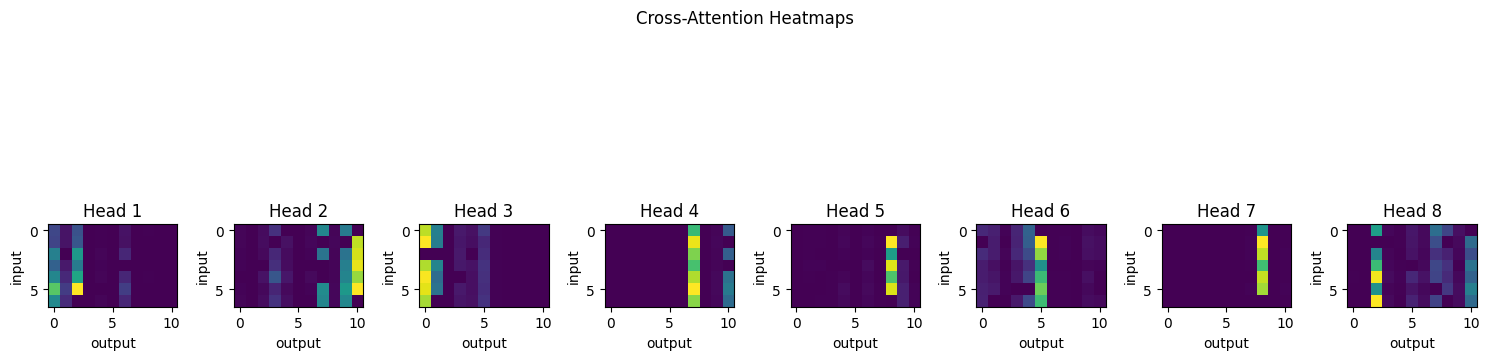

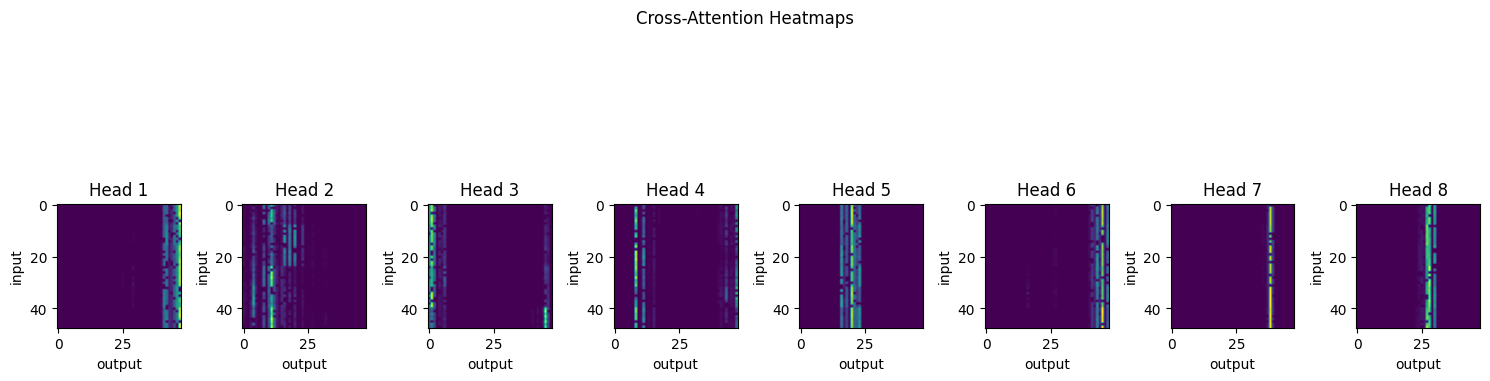

In [32]:
plot_cross_attention(cross_attn_w, inp_seq_lens=inp_seq_lens, outp_seq_lens=outp_seq_lens)
plot_cross_attention(cross_attn_w)

#### Test Transformer decoder

In [112]:
dec = TransformerDecoder(num_layers=1).cuda()
summary(model=dec)

Layer (type:depth-idx)                             Param #
TransformerDecoder                                 --
├─Linear: 1-1                                      262,144
├─ModuleList: 1-2                                  --
│    └─TransformerDecoderLayer: 2-1                --
│    │    └─MultiHeadSelfAttention: 3-1            8,388,608
│    │    └─MultiHeadCrossAttention: 3-2           6,291,456
│    │    └─LayerNormalization: 3-3                1,024
│    │    └─LayerNormalization: 3-4                1,024
│    │    └─Sequential: 3-5                        2,099,712
│    │    └─LayerNorm: 3-6                         1,024
│    │    └─Dropout: 3-7                           --
Total params: 17,044,992
Trainable params: 17,044,992
Non-trainable params: 0

#### Test Transformer Decoder

In [113]:
dec_out, self_attn_ws, cross_attn_ws = dec(
    learned_tokens, 
    inp_lens=inp_seq_lens, 
)

dec_out.shape, self_attn_ws.shape, cross_attn_ws.shape

(torch.Size([4, 48, 512]),
 torch.Size([4, 8, 48, 48]),
 torch.Size([4, 8, 48, 48]))

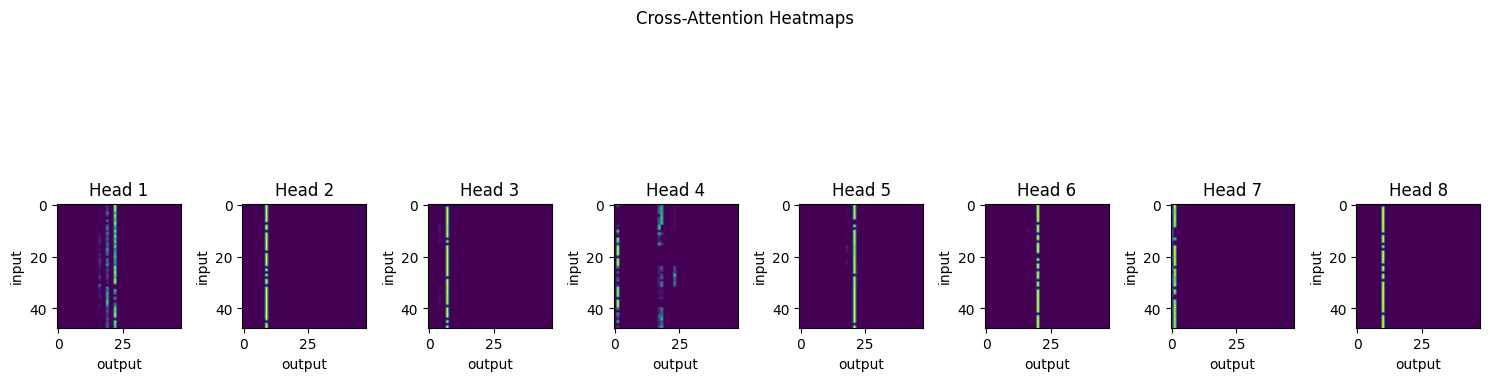

In [114]:
plot_cross_attention(cross_attn_ws)

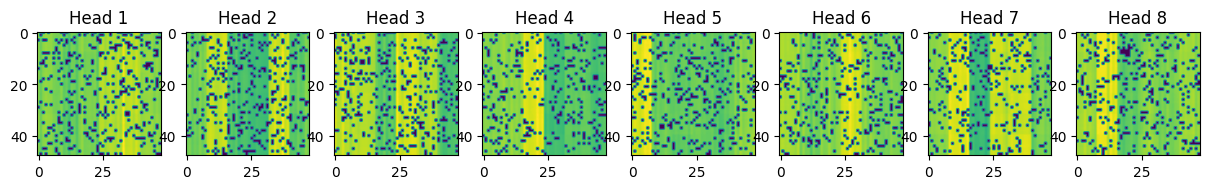

In [116]:
plot_self_attention(self_attn_ws, example_idx=2)

#### Action Generator

In [118]:
generator = ActionGenerator().cuda()
print(generator)
summary(generator)

ActionGenerator(
  (pooler): CustomPooling()
  (norm): LayerNormalization(
    (layer): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  )
  (proj): Linear(in_features=512, out_features=52, bias=True)
  (_softmax): LogSoftmax(dim=-1)
)


Layer (type:depth-idx)                   Param #
ActionGenerator                          --
├─CustomPooling: 1-1                     --
├─LayerNormalization: 1-2                --
│    └─LayerNorm: 2-1                    1,024
├─Linear: 1-3                            26,676
├─LogSoftmax: 1-4                        --
Total params: 27,700
Trainable params: 27,700
Non-trainable params: 0

In [119]:
preds = generator(dec_out)
preds.shape

torch.Size([4, 8, 52])

In [120]:
predicted_next_tok = preds[:, -1, :].argmax(dim=-1)
predicted_next_tok.shape, predicted_next_tok

(torch.Size([4]), tensor([27, 27, 27, 27], device='cuda:0'))

### RT-1 Decoder

In [ ]:
class RT1Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embedding = nn.Embedding()
        self.self_attention = TransformerDecoder()
        self.norm = LayerNormalization()
        self.action_generator = ActionGenerator()
        
    def _decode_predictions(self, preds, method:str="greedy"):
        """
            Args:
                preds: predictions (logits)
                method: decoding strategy. one of ["greedy", "beam-search"]
                
            Returns:
                actions: decoded predictions as sequence of actions.
            
        """
        pass
    
    def forward(
        self, 
        encoder_outputs:torch.Tensor, 
        inp_lens:torch.Tensor,
        self_mask:torch.Tensor=None, 
        cross_mask:torch.tensor=None,        
        debug:bool=False        
        
        
        y=None, 
        tf_rate=1.
    ):
        max_output_length = encoder_outputs.shape[1]
        
        # Initialize the input to the decoder
        input_embedding = self.embedding(config.TARGETS_MAPPING["[SOS]"])  # Start of sequence token

        for _ in range(config.MAX_OUT_SEQ_LEN):
            # Forward pass through the decoder layers
            dec_out, self_attn_ws, cross_attn_ws = self.self_attention(
                                                        encoder_outputs, # learned tokens from encoder
                                                        inp_lens=inp_seq_lens, 
                                                    )

            # Get the last predicted token (Greedy decoding)
            predicted_token = dec_out[:, -1, :].argmax(dim=-1)

            # Append the predicted token to the generated sequence
            generated_sequence = torch.cat((generated_sequence, predicted_token), dim=-1)

            # Check for the end-of-sequence token (EOS)
            if predicted_token.item() == config.TARGETS_MAPPING["[EOS]"]:
                break

        # # Convert the generated sequence to a list of token IDs
        # generated_sequence = generated_sequence.squeeze().tolist()

### RT-1 

In [ ]:
class RT1(pl.LightningModule):
    def __init__(
        self
    ):
        super().__init__()
        self.encoder = RT1Encder()
        self.decoder = RT1Decoder()

        # freeze BERT Embedding layer
        for param in self.input_seq_embedding.parameters():
            param.requires_grad = False 
            
        self.target_seq_embedding = nn.Sequential(
            nn.Embedding(
                num_embeddings=config.TARGET_VOCAB_SIZE, 
                embedding_dim=config.EMBEDDING_DIM, 
                padding_idx=config.TGT_PAD_TOK_ID
            ),
            LayerNormalization(),
            nn.Dropout(p=.1)

        )
        
    def forward(self, input_ids, attn_mask, token_type_ids, imgs):
        
        tokens = self.encode(input_ids, attn_mask, token_type_ids, imgs)
        out = self.decode(tokens, )
    
    def encode(self, input_ids, attn_mask, token_type_ids, imgs):
        return self.encoder(input_ids, attn_mask, token_type_ids, imgs)
    
    def decode(self, enc_outputs, x_mask, y, y_mask):
        return self.decoder(y, enc_outputs, src_mask, tgt_mask)
    
    def configure_optimizers(self):
        pass
    
    def training_step(self, batch, batch_idx):
        pass
    
    def validation_step(self, batch, batch_idx):
        pass
    
    def test_step(self, batch, batch_idx):
        pass
    
    def compute_loss(self, outputs, targets):
        pass